In [45]:
#Importálom a korábbi notebookoban készített modell -t és baseline -t és Dataset -et
import sys
import os
sys.path.append(os.path.abspath('/content/lib')) #import Dataloader

from dataloader import FlagDataset
from seed_everything import seed_everything

seed_everything(42)

In [ ]:
!unzip /content/processed.zip

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt



# Defining Training loop

In [47]:
#Define the training loop

import torch
import torch.nn as nn
import torch.optim as optim
import time

def train_model(model, train_loader, val_loader, tag="experiment",
                epochs=50, lr=0.001, device='cpu', early_stop_patience=10):
    """
    Trains a PyTorch model with Early Stopping and LR Scheduling.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        tag (str): Suffix for the saved model file (e.g., 'fast_compact').
        epochs (int): Maximum number of epochs.
        lr (float): Initial learning rate.
        device (str): 'cuda' or 'cpu'.
        early_stop_patience (int): Epochs to wait for improvement before stopping.

    Returns:
        model: The model with the BEST weights loaded.
        history: Dictionary containing loss and accuracy curves.
    """

    # 1. Setup
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Scheduler: Reduce LR by half if val_loss doesn't improve for 5 epochs
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_loss = float('inf')
    early_stop_counter = 0
    save_path = f"best_model_{tag}.pth"

    print(f"\n--- Starting Training: {tag} ---")
    start_time = time.time()

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = train_loss / total_train
        epoch_train_acc = correct_train / total_train

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = val_loss / total_val
        epoch_val_acc = correct_val / total_val

        # --- Logging ---
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Step Scheduler
        scheduler.step(epoch_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1:02d} | LR: {current_lr:.1e} | "
              f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.2%} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.2%}")

        # --- Early Stopping & Saving ---
        if epoch_val_loss < (best_val_loss - 0.001):
            best_val_loss = epoch_val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print(f"\n--- Early Stopping Triggered at Epoch {epoch+1} ---")
            break

    # Final Cleanup
    duration = time.time() - start_time
    print(f"Training Complete. Best Val Loss: {best_val_loss:.4f}. Time: {duration:.0f}s")

    # Load best weights so the returned model is optimized
    model.load_state_dict(torch.load(save_path))

    return model, history

# Doing the training

In [56]:
# --- 1. CONFIGURATION FOR DATASET ---
CSV_FILE = '/content/processed/consolidated_labels.csv'

BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EARLY_STOP_PATIENCE = 20
FLAG_TARGET_LENGTH = 512

In [57]:
#Load and split data

# A. Load Data
full_dataset = FlagDataset(csv_file=CSV_FILE, target_length=FLAG_TARGET_LENGTH) #Using the choosen target length
num_classes = len(full_dataset.classes)
print(f"Loaded {len(full_dataset)} samples with {num_classes} classes.")

# B. Split Data (Option 1: Fractional)
# [0.7, 0.2, 0.1]
train_ds, val_ds, test_ds = random_split(full_dataset, [0.7, 0.2, 0.1])

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

# C. DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Loaded 516 samples with 6 classes.
Train: 362 | Val: 103 | Test: 51


In [58]:
from baseline_model import BaselineClassifier
from model import FlagClassifier


# 1. Train the baseline model

#Resetting seed
seed_everything(42) # <--- Reset state

baseline_model = BaselineClassifier(num_classes=6)
baseline_model, baseline_history = train_model(
    baseline_model, train_loader, val_loader,
    tag="baseline",
    epochs=EPOCHS,
    device=DEVICE,
    early_stop_patience=EARLY_STOP_PATIENCE
)

# 2. Train the hopefully better model

#Resetting seed
seed_everything(42) # <--- Reset state

model = FlagClassifier(num_classes=6)
model, model_history = train_model(
    model, train_loader, val_loader,
    tag="FlagClassifier",
    epochs=EPOCHS,
    device=DEVICE,
    early_stop_patience=EARLY_STOP_PATIENCE
)



--- Starting Training: baseline ---
Epoch 01 | LR: 1.0e-03 | Train Loss: 2.9424 Acc: 17.40% | Val Loss: 1.9411 Acc: 8.74%
Epoch 02 | LR: 1.0e-03 | Train Loss: 2.4444 Acc: 22.10% | Val Loss: 1.9335 Acc: 8.74%
Epoch 03 | LR: 1.0e-03 | Train Loss: 2.1568 Acc: 22.65% | Val Loss: 1.9352 Acc: 8.74%
Epoch 04 | LR: 1.0e-03 | Train Loss: 1.9916 Acc: 19.06% | Val Loss: 1.9330 Acc: 8.74%
Epoch 05 | LR: 1.0e-03 | Train Loss: 1.8989 Acc: 16.02% | Val Loss: 1.9221 Acc: 8.74%
Epoch 06 | LR: 1.0e-03 | Train Loss: 1.8463 Acc: 14.92% | Val Loss: 1.9063 Acc: 8.74%
Epoch 07 | LR: 1.0e-03 | Train Loss: 1.8134 Acc: 14.64% | Val Loss: 1.8868 Acc: 7.77%
Epoch 08 | LR: 1.0e-03 | Train Loss: 1.7922 Acc: 14.92% | Val Loss: 1.8634 Acc: 7.77%
Epoch 09 | LR: 1.0e-03 | Train Loss: 1.7757 Acc: 15.47% | Val Loss: 1.8358 Acc: 7.77%
Epoch 10 | LR: 1.0e-03 | Train Loss: 1.7588 Acc: 16.85% | Val Loss: 1.8019 Acc: 7.77%
Epoch 11 | LR: 1.0e-03 | Train Loss: 1.7479 Acc: 21.82% | Val Loss: 1.7674 Acc: 11.65%
Epoch 12 | LR: 1

A tanítást erőforráslimitációk miatt Google Colab -ban csináltam, az elmentett modelleket feltöltöttem a git repo -ba.

# Inference

## function definitions

In [59]:
# Setup plot methods
import matplotlib.pyplot as plt
import torch
import time
import numpy as np

def plot_comparison(histories):
    """
    Plots Train/Val Loss and Accuracy for multiple models.

    Args:
        histories (dict): { 'ModelName': history_dict, ... }
    """
    plt.figure(figsize=(12, 5))

    # --- Plot Loss ---
    plt.subplot(1, 2, 1)
    for name, hist in histories.items():
        # Plot Validation Loss (Solid line)
        plt.plot(hist['val_loss'], label=f"{name} Val", linestyle='-')
        # Plot Training Loss (Dashed line, lighter)
        plt.plot(hist['train_loss'], label=f"{name} Train", linestyle='--', alpha=0.5)

    plt.title("Loss Curves (Lower is better)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- Plot Accuracy ---
    plt.subplot(1, 2, 2)
    for name, hist in histories.items():
        plt.plot(hist['val_acc'], label=f"{name} Val", linestyle='-')
        # Optional: Plot Train Acc if you want to check overfitting
        # plt.plot(hist['train_acc'], label=f"{name} Train", linestyle='--', alpha=0.5)

    plt.title("Accuracy Curves (Higher is better)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def benchmark_models(models_dict, test_loader, device='cpu'):
    """
    Runs inference on a test set to measure Accuracy, Latency, and Model Size.
    """
    results = []

    print(f"{'Model Name':<20} | {'Params':<10} | {'Acc':<8} | {'Latency (ms)':<15}")
    print("-" * 65)

    for name, model in models_dict.items():
        model = model.to(device)
        model.eval()

        # 1. Count Parameters
        num_params = sum(p.numel() for p in model.parameters())

        # 2. Run Inference & Time it
        correct = 0
        total = 0
        start_time = time.time()

        with torch.no_grad():
            for inputs, labels, _ in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        end_time = time.time()

        # 3. Calculate Metrics
        accuracy = correct / total
        total_time_ms = (end_time - start_time) * 1000
        avg_latency = total_time_ms / total # Time per single sample

        print(f"{name:<20} | {num_params:<10,} | {accuracy:.2%} | {avg_latency:.4f} ms")

        results.append({
            'name': name,
            'params': num_params,
            'accuracy': accuracy,
            'latency': avg_latency
        })

    return results

## Comparing and Benchmark

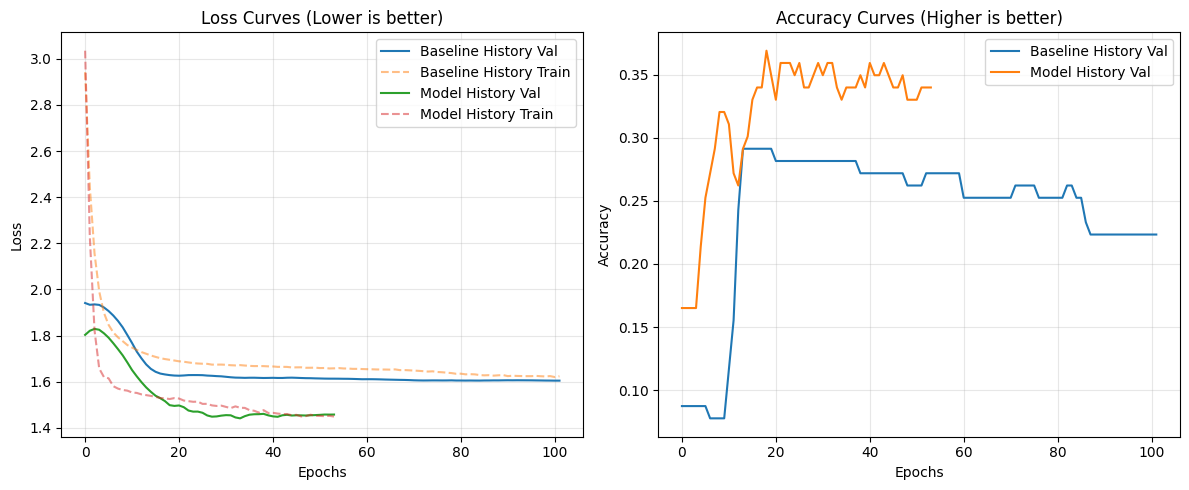


--- Final Benchmark Results ---
Model Name           | Params     | Acc      | Latency (ms)   
-----------------------------------------------------------------
BaselineModel        | 206        | 25.24% | 0.5862 ms
Model                | 2,982      | 33.98% | 0.5351 ms


In [60]:
# --- 1. Setup Data & Device ---
# Assuming train_loader and val_loader are already defined
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Train Models ---
# Dictionary to store results for plotting
all_histories = {}
trained_models = {}


all_histories['Baseline History'] = baseline_history
trained_models['BaselineModel'] = baseline_model

all_histories['Model History'] = model_history
trained_models['Model'] = model

# --- 3. Visualize & Benchmark ---

# A. Plot Learning Curves
plot_comparison(all_histories)

# B. Run Inference Benchmark (Speed vs Accuracy)
print("\n--- Final Benchmark Results ---")
# Note: Using val_loader as test_loader for this example
stats = benchmark_models(trained_models, val_loader, device=DEVICE)

## A definiált modell valóban jobbnak tűnik a Baseline modellnél 🙂